# Train LSTM models

## Read data

In [1]:
import os
import re
import pandas as pd
import numpy as np
import random
import sklearn
import codecs
import collections
from tqdm import tqdm
import torch

from sklearn.metrics import classification_report, accuracy_score

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [2]:
TRAIN_DIR = "./data/training/"
TRAIN_SUFFIX = "-train.txt"

DEV_DIR = "./data/development/"
DEV_SUFFIX = "-dev.txt"

TEST_DIR = "./data/test-gold/"
TEST_SUFFIX = "-test-gold.txt"

YEAR_PREFIX = "2018-"
FILE_PREFIX = "EI-oc-En-"

EMOTIONS = ["anger", "fear", "joy", "sadness"] 
LABEL_EMOTIONS = {i: emo for i, emo in enumerate(EMOTIONS)}
EMOTIONS_LABEL = {emo: i for i, emo in enumerate(EMOTIONS)}

In [3]:
TRAIN_FILES = []
DEV_FILES = []
TEST_FILES = []

for emo in EMOTIONS: 
    TRAIN_FILES += [TRAIN_DIR + FILE_PREFIX + emo + TRAIN_SUFFIX]
    DEV_FILES += [DEV_DIR + YEAR_PREFIX + FILE_PREFIX + emo + DEV_SUFFIX]
    TEST_FILES += [TEST_DIR + YEAR_PREFIX + FILE_PREFIX + emo + TEST_SUFFIX]

for file in TRAIN_FILES + DEV_FILES + TEST_FILES:
    print(file, os.path.exists(file))

./data/training/EI-oc-En-anger-train.txt True
./data/training/EI-oc-En-fear-train.txt True
./data/training/EI-oc-En-joy-train.txt True
./data/training/EI-oc-En-sadness-train.txt True
./data/development/2018-EI-oc-En-anger-dev.txt True
./data/development/2018-EI-oc-En-fear-dev.txt True
./data/development/2018-EI-oc-En-joy-dev.txt True
./data/development/2018-EI-oc-En-sadness-dev.txt True
./data/test-gold/2018-EI-oc-En-anger-test-gold.txt True
./data/test-gold/2018-EI-oc-En-fear-test-gold.txt True
./data/test-gold/2018-EI-oc-En-joy-test-gold.txt True
./data/test-gold/2018-EI-oc-En-sadness-test-gold.txt True


In [4]:
TRAIN_DATA = pd.concat(pd.read_csv(f, sep='\t') for f in TRAIN_FILES)
TRAIN_DATA = sklearn.utils.shuffle(TRAIN_DATA)
TRAIN_DATA        

,ID,Tweet,Affect Dimension,Intensity Class
526,2017-En-41199,Incredibly shocked and disappointed with @unit...,sadness,3: high amount of sadness can be inferred
494,2017-En-30873,If yiu don't respond .o an email within 7 days...,joy,0: no joy can be inferred
724,2017-En-30332,Watch this amazing live.ly broadcast by @maisi...,joy,2: moderate amount of joy can be inferred
879,2017-En-31279,But I got to see her last when she was lively ...,joy,0: no joy can be inferred
2095,2017-En-21925,@ThomasHCrown @laurakfillault As a historic ev...,fear,0: no fear can be inferred
...,...,...,...,...
2071,2017-En-22224,today afghanistan tell us where the terrorism ...,fear,2: moderate amount of fear can be inferred
1238,2017-En-31048,#IfIWerePresident \nMy goal would be for us al...,joy,0: no joy can be inferred
1273,2017-En-31241,@1barkcom Thank you for the #follow. Looking f...,joy,2: moderate amount of joy can be inferred
1437,2017-En-31232,"The best part of this day, Jesus, is to snuggl...",joy,3: high amount of joy can be inferred


In [5]:
TRAIN_DATA["Category"] = TRAIN_DATA["Affect Dimension"]
TRAIN_DATA["Label"] = TRAIN_DATA["Affect Dimension"].apply(lambda x: EMOTIONS_LABEL[x])
TRAIN_DATA["Intensity"] = TRAIN_DATA["Intensity Class"].apply(lambda x: int(x[0]))
TRAIN_DATA

,ID,Tweet,Affect Dimension,Intensity Class,Category,Label,Intensity
526,2017-En-41199,Incredibly shocked and disappointed with @unit...,sadness,3: high amount of sadness can be inferred,sadness,3,3
494,2017-En-30873,If yiu don't respond .o an email within 7 days...,joy,0: no joy can be inferred,joy,2,0
724,2017-En-30332,Watch this amazing live.ly broadcast by @maisi...,joy,2: moderate amount of joy can be inferred,joy,2,2
879,2017-En-31279,But I got to see her last when she was lively ...,joy,0: no joy can be inferred,joy,2,0
2095,2017-En-21925,@ThomasHCrown @laurakfillault As a historic ev...,fear,0: no fear can be inferred,fear,1,0
...,...,...,...,...,...,...,...
2071,2017-En-22224,today afghanistan tell us where the terrorism ...,fear,2: moderate amount of fear can be inferred,fear,1,2
1238,2017-En-31048,#IfIWerePresident \nMy goal would be for us al...,joy,0: no joy can be inferred,joy,2,0
1273,2017-En-31241,@1barkcom Thank you for the #follow. Looking f...,joy,2: moderate amount of joy can be inferred,joy,2,2
1437,2017-En-31232,"The best part of this day, Jesus, is to snuggl...",joy,3: high amount of joy can be inferred,joy,2,3


In [6]:
TRAIN_DATA["Category"].value_counts()

fear       2252
anger      1701
joy        1616
sadness    1533
Name: Category, dtype: int64

In [7]:
TRAIN_CATEGORY_WEIGHTS = TRAIN_DATA["Category"].value_counts().to_dict()
TRAIN_LABEL_WEIGHTS =  TRAIN_DATA["Label"].value_counts().to_dict()

In [8]:
DEV_DATA = pd.concat(pd.read_csv(f, sep='\t') for f in DEV_FILES)
DEV_DATA = sklearn.utils.shuffle(DEV_DATA)
DEV_DATA

,ID,Tweet,Affect Dimension,Intensity Class
321,2018-En-01824,God this match is dull #Wimbledon,anger,1: low amount of anger can be inferred
62,2018-En-03227,Not only has my flight been delayed numerous t...,fear,1: low amount of fear can be inferred
327,2018-En-00695,@austin_j_powers @I_am_bumface @R9Rai @Holborn...,fear,1: low amount of fear can be inferred
166,2018-En-03038,James Clapper 'scary and disturbing'. #25thAm...,fear,2: moderate amount of fear can be inferred
369,2018-En-03488,I wish EVERYONE could see how #MSNBC #CNN talk...,anger,1: low amount of anger can be inferred
...,...,...,...,...
55,2018-En-00823,Only halfway through #madeforlove by @AlissaNu...,joy,3: high amount of joy can be inferred
266,2018-En-01671,Nigga write me talking bout I dreamt about you...,sadness,0: no sadness can be inferred
207,2018-En-00657,Damn I'm tired as hell I never get a off day d...,sadness,2: moderate amount of sadness can be inferred
235,2018-En-03719,"The blackest abyss of despair, Alonzo",sadness,2: moderate amount of sadness can be inferred


In [9]:
DEV_DATA["Category"] = DEV_DATA["Affect Dimension"]
DEV_DATA["Label"] = DEV_DATA["Affect Dimension"].apply(lambda x: EMOTIONS_LABEL[x])
DEV_DATA["Intensity"] = DEV_DATA["Intensity Class"].apply(lambda x: int(x[0]))
DEV_DATA

,ID,Tweet,Affect Dimension,Intensity Class,Category,Label,Intensity
321,2018-En-01824,God this match is dull #Wimbledon,anger,1: low amount of anger can be inferred,anger,0,1
62,2018-En-03227,Not only has my flight been delayed numerous t...,fear,1: low amount of fear can be inferred,fear,1,1
327,2018-En-00695,@austin_j_powers @I_am_bumface @R9Rai @Holborn...,fear,1: low amount of fear can be inferred,fear,1,1
166,2018-En-03038,James Clapper 'scary and disturbing'. #25thAm...,fear,2: moderate amount of fear can be inferred,fear,1,2
369,2018-En-03488,I wish EVERYONE could see how #MSNBC #CNN talk...,anger,1: low amount of anger can be inferred,anger,0,1
...,...,...,...,...,...,...,...
55,2018-En-00823,Only halfway through #madeforlove by @AlissaNu...,joy,3: high amount of joy can be inferred,joy,2,3
266,2018-En-01671,Nigga write me talking bout I dreamt about you...,sadness,0: no sadness can be inferred,sadness,3,0
207,2018-En-00657,Damn I'm tired as hell I never get a off day d...,sadness,2: moderate amount of sadness can be inferred,sadness,3,2
235,2018-En-03719,"The blackest abyss of despair, Alonzo",sadness,2: moderate amount of sadness can be inferred,sadness,3,2


## Tweet cleaning

In [10]:
#For Pre-Processing
import emoji
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize

import nltk
nltk.download('wordnet')

stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# For visualizing
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to /home/cwh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
def decode_emoji(text):
    output = []
    for t in emoji.demojize(text).split():
        output.extend(t.split("_"))
    return ' '.join(output)

def decode_HTML(text):
    return BeautifulSoup(text, 'lxml').get_text()

def remove_mention(text):
    return re.sub(r'@[A-Za-z0-9]+', '', text)
    
def remove_URL(text):
    return re.sub(r"http\S+", "", text)

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', ' ', text)

def correct_repeatted_letters(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def to_lowercase(text):
    return ' '.join([w.lower() for w in text.split()])
 
def lemmatize_stemming(text):
    return ' '.join([stemmer.stem(lemmatizer.lemmatize(w, pos='v'))
                     for w in text.split()])

def remove_stop_words(text):
    return ' '.join([w for w in text.split() if w not in stop_words])

In [12]:
def pre_process(text):
    text = decode_emoji(text)
    text = decode_HTML(text)
    text = remove_mention(text)
    text = remove_URL(text)
    text = remove_punctuation(text)
    text = correct_repeatted_letters(text)
    text = to_lowercase(text)       
    text = lemmatize_stemming(text)
    text = remove_stop_words(text)
    return text

In [13]:
for t in TRAIN_DATA["Tweet"][:5]:
    print("BEFORE:", t)
    print("AFTER :", pre_process(t))
    print()

BEFORE: Incredibly shocked and disappointed with @united customer service. Really making me rethink flying with them in the future. #unhappy
AFTER : incred shock disappoint custom servic realli make rethink fli futur unhappi

BEFORE: If yiu don't respond .o an email within 7 days, you willxbe killed by an animated gif of the girl froa The Ri.g.
AFTER : yiu respond email within 7 day willxb kill anim gif girl froa ri g

BEFORE: Watch this amazing live.ly broadcast by @maisiev #lively #musically
AFTER : watch amaz live ly broadcast live music

BEFORE: But I got to see her last when she was lively and talkative and I was able to tell her I loved her so that's what matters.
AFTER : get see last live talkat abl tell love matter

BEFORE: @ThomasHCrown @laurakfillault As a historic evangelical, I wonder if the Donatists had a point? What dreadful clergy in my fmr. circles.
AFTER : histor evangel wonder donatist point dread clergi fmr circl



In [14]:
# Train data cleaning
TRAIN_DATA["Text"] = TRAIN_DATA["Tweet"].apply(lambda s: pre_process(s))
TRAIN_DATA["Text_len"] = TRAIN_DATA["Text"].apply(lambda s: len(s.split()))
TRAIN_DATA.head(5)

,ID,Tweet,Affect Dimension,Intensity Class,Category,Label,Intensity,Text,Text_len
526,2017-En-41199,Incredibly shocked and disappointed with @unit...,sadness,3: high amount of sadness can be inferred,sadness,3,3,incred shock disappoint custom servic realli m...,11
494,2017-En-30873,If yiu don't respond .o an email within 7 days...,joy,0: no joy can be inferred,joy,2,0,yiu respond email within 7 day willxb kill ani...,14
724,2017-En-30332,Watch this amazing live.ly broadcast by @maisi...,joy,2: moderate amount of joy can be inferred,joy,2,2,watch amaz live ly broadcast live music,7
879,2017-En-31279,But I got to see her last when she was lively ...,joy,0: no joy can be inferred,joy,2,0,get see last live talkat abl tell love matter,9
2095,2017-En-21925,@ThomasHCrown @laurakfillault As a historic ev...,fear,0: no fear can be inferred,fear,1,0,histor evangel wonder donatist point dread cle...,9


In [15]:
# Dev data cleaning
DEV_DATA["Text"] = DEV_DATA["Tweet"].apply(lambda s: pre_process(s))
DEV_DATA["Text_len"] = DEV_DATA["Text"].apply(lambda s: len(s.split()))
DEV_DATA.head(5)

,ID,Tweet,Affect Dimension,Intensity Class,Category,Label,Intensity,Text,Text_len
321,2018-En-01824,God this match is dull #Wimbledon,anger,1: low amount of anger can be inferred,anger,0,1,god match dull wimbledon,4
62,2018-En-03227,Not only has my flight been delayed numerous t...,fear,1: low amount of fear can be inferred,fear,1,1,onli flight delay numer time provid snack cart...,9
327,2018-En-00695,@austin_j_powers @I_am_bumface @R9Rai @Holborn...,fear,1: low amount of fear can be inferred,fear,1,1,j power bumfac absolut shock behavour,6
166,2018-En-03038,James Clapper 'scary and disturbing'. #25thAm...,fear,2: moderate amount of fear can be inferred,fear,1,2,jam clapper scari disturb 25thamendmentnow imp...,9
369,2018-En-03488,I wish EVERYONE could see how #MSNBC #CNN talk...,anger,1: low amount of anger can be inferred,anger,0,1,wish everyon could see msnbc cnn talk trump sp...,13


count    7102.000000
mean        9.513377
std         4.402350
min         1.000000
25%         6.000000
50%         9.000000
75%        12.000000
max        79.000000
Name: Text_len, dtype: float64


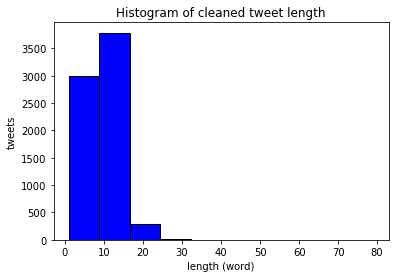

In [16]:
print(TRAIN_DATA["Text_len"].describe())

plt.hist(TRAIN_DATA["Text_len"], color='blue', edgecolor='black')
plt.title('Histogram of cleaned tweet length')
plt.xlabel('length (word)')
plt.ylabel('tweets')
plt.show()

In [17]:
for i, t in TRAIN_DATA.iterrows():
    if t["Text_len"] > 30:
        print("BEFORE:", t["Tweet"])
        print("AFTER :", t["Text"])
        print()

BEFORE: i will never watch greys anatomy ever ever ever ever ever again if Shonda Rimes takes away another OG character☹️☹️☹️☹️☹️☹️☹️☹️☹️☹️ #fuming
AFTER : never watch grey anatomi ever ever ever ever ever shonda rim take away anoth og charact frown face selector frown face selector frown face selector frown face selector frown face selector frown face selector frown face selector frown face selector frown face selector frown face selector fume

BEFORE: Good morning, Trondheim! #optimism #productivity ⛅️❤️🇳🇴🏢💻🖥🏋🏻💪🏼📺🍿
AFTER : good morn trondheim optim product sun behind cloud red heart selector norway offic build laptop comput desktop comput person lift weight light skin tone flex bicep medium light skin tone televis popcorn

BEFORE: i will never watch greys anatomy ever ever ever ever ever again if Shonda Rimes takes away another OG character☹️☹️☹️☹️☹️☹️☹️☹️☹️☹️ 
AFTER : never watch grey anatomi ever ever ever ever ever shonda rim take away anoth og charact frown face selector frown fa

## Retrive pre-trained GloVe word embedding

In [18]:
# zip_file_url = "http://nlp.stanford.edu/data/glove.twitter.27B.zip"
print('loading word embeddings from GloVe...')

embeddings_index = {}
f = codecs.open('../gloVe/glove.twitter.27B.200d.txt', encoding='utf-8')

for line in tqdm(f, total=1193515):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

  0%|          | 861/1193515 [00:00<02:18, 8603.81it/s]

loading word embeddings from GloVe...


100%|██████████| 1193515/1193515 [01:45<00:00, 11325.08it/s]

found 1193514 word vectors


## tokenzing data

In [19]:
counter = collections.Counter(word for text in TRAIN_DATA['Text'] for word in text.split())
words_list = sorted(counter.items(), key=lambda x:x[1], reverse=True)
word_index = {word[0]: i+1 for i, word in enumerate(words_list)}
print("dictionary size: ", len(word_index))

dictionary size:  10000


In [20]:
#embedding matrix
print('preparing embedding matrix...')

words_not_found = []
nb_words = len(word_index) + 1
embed_dim = 200
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)

print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
print("sample words not found: ", np.random.choice(words_not_found, 10))

preparing embedding matrix...
number of null word embeddings: 2867
sample words not found:  ['overdos' 'pinafor' 'nojobsinbiolog' '3499' 'debates2016' 'lovinle'
 'endlessposs' 'willxb' 'ruthann' 'milleni']


In [21]:
def words_to_seq(words):
    return np.array([word_index.get(word, 0) for word in words])

def tokenize(data):
    X_data = []
    y_data = []
    
    for X, y in zip(data["Tweet"], data["Label"]):
        words = pre_process(X).split()
        if len(words) > 0:
            X_data.append(words_to_seq((words)))
            y_data.append(y)
            
    return X_data, y_data

In [22]:
X_train, y_train = tokenize(TRAIN_DATA)
X_dev, y_dev = tokenize(DEV_DATA)

In [23]:
label_distribution = collections.Counter(y_train)
class_weights = [label_distribution[i] / sum(label_distribution.values()) for i in range(4)]
class_weights

[0.23950999718389185,
 0.31709377640101377,
 0.22754153759504364,
 0.21585468882005068]

## LSTM Model

In [24]:
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

class LSTM(nn.Module):

    def __init__(self, hidden_dim, no_layers, dropout, train_emb):
        super(LSTM, self).__init__()
        self.no_layers = no_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
        self.embedding.weight.requires_grad = train_emb
        
        self.dimension = hidden_dim
        self.lstm = nn.LSTM(input_size=embed_dim,
                            hidden_size=self.dimension,
                            num_layers=self.no_layers,
                            batch_first=True)
        self.drop = nn.Dropout(p=dropout)

        self.fc = nn.Linear(self.hidden_dim, 4)

    def forward(self, text):

        text_len = np.array([len(t) for t in text]) 
        
        padded_input = pad_sequence(text, batch_first=True)
        embbed_input = self.embedding(padded_input)
        packed_input = pack_padded_sequence(embbed_input, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, output_len = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = torch.cat([torch.mean(t[:l], 0, keepdim=True) for (t, l) in zip(output, output_len)])
        text_fea = self.drop(out_forward)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out  

## bi-LSTM model

In [25]:
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

class bi_LSTM(nn.Module):

    def __init__(self, hidden_dim, no_layers, dropout, train_emb):
        super(bi_LSTM, self).__init__()
        self.no_layers = no_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
        self.embedding.weight.requires_grad = train_emb
        
        self.dimension = hidden_dim
        self.lstm = nn.LSTM(input_size=embed_dim,
                            hidden_size=self.dimension,
                            num_layers=self.no_layers,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=dropout)
        self.fc = nn.Linear(2 * self.hidden_dim, 4)

    def forward(self, text):

        text_len = np.array([len(t) for t in text]) 
        
        padded_input = pad_sequence(text, batch_first=True)
        embbed_input = self.embedding(padded_input)
        packed_input = pack_padded_sequence(embbed_input, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, output_len = pad_packed_sequence(packed_output, batch_first=True)

        
        out_forward = torch.cat([torch.mean(t[:l, :self.dimension], 0, keepdim=True) for (t, l) in zip(output, output_len)])
        out_reverse = torch.cat([torch.mean(t[-l:, self.dimension:], 0, keepdim=True) for (t, l) in zip(output, output_len)])             
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

## Main training function

In [26]:
def train(model, verbose=True):
    
    # shared settings
    epochs = 20
    batch_size = 100
    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights))
    clip = 5

    valid_loss_min = np.Inf
    epoch_tr_loss,epoch_vl_loss = [],[]
    epoch_tr_acc,epoch_vl_acc = [],[]

    for epoch in tqdm(range(epochs)):
        train_losses = []
        train_acc = 0.0
        model.train()

        for start in range(0, len(X_train), batch_size):

            inputs = [torch.from_numpy(t) for t in X_train[start: start+batch_size]]
            labels = torch.Tensor(y_train[start: start+batch_size]).long()

            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            train_acc += acc(output, labels)

            #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)

        with torch.no_grad():
            val_losses = []
            val_acc = 0.0
            model.eval()

            for start in range(0, len(X_dev), batch_size): 
                v_inputs = [torch.from_numpy(t) for t in X_dev[start: start+batch_size]]
                v_labels = torch.Tensor(y_dev[start: start+batch_size]).long()

                output = model(v_inputs)
                val_loss = criterion(output, v_labels)

                val_losses.append(val_loss.item())
                accuracy = acc(output, v_labels)
                val_acc += accuracy

        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_train_acc = train_acc/len(X_train)
        epoch_val_acc = val_acc/len(X_dev)
        epoch_tr_loss.append(epoch_train_loss)
        epoch_vl_loss.append(epoch_val_loss)
        epoch_tr_acc.append(epoch_train_acc)
        epoch_vl_acc.append(epoch_val_acc)


        if verbose:
            print(25*'==')
            print(f'Epoch {epoch+1}') 
            print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
            print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')

        if epoch_val_loss <= valid_loss_min:
            # update model state only when the validation loss decreased
            torch.save(model.state_dict(), WORKING_PATH)
            if verbose:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
            valid_loss_min = epoch_val_loss
 
    if verbose:
        # plot acc, loss per epoche
        plot_acc_loss(epoch_tr_acc, epoch_vl_acc, epoch_tr_loss, epoch_vl_loss)

    # report dev acc
    return report(model, verbose)

## Helper functions

In [27]:
# function to predict accuracy
def acc(pred, label):
    pred = torch.argmax(pred, 1)
    return torch.sum(pred == label).item()

In [28]:
# function to plot the accuracy and loss
def plot_acc_loss(tr_acc, vl_acc, tr_loss, vl_loss):
    fig = plt.figure(figsize = (20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(tr_acc, label='Train Acc')
    plt.plot(vl_acc, label='Validation Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(tr_loss, label='Train loss')
    plt.plot(vl_loss, label='Validation loss')
    plt.title("Loss")
    plt.legend()
    plt.grid()

    plt.show()

In [29]:
# function to report the accuracy on dev set
def report(model, verbose=True):
    saved_model = model
    saved_model.load_state_dict(torch.load(WORKING_PATH))
    saved_model.eval()

    inputs = v_inputs = [torch.from_numpy(t) for t in X_dev]
    output = saved_model(inputs)
    y_pred = torch.argmax(output, 1).data.numpy()

    if verbose:
        print(classification_report(y_dev, y_pred, target_names=EMOTIONS))
        print("Accuracy=", accuracy_score(y_dev, y_pred))
    return accuracy_score(y_dev, y_pred)

In [30]:
! mkdir -p ./LSTM_working
WORKING_PATH = 'LSTM_working/state_dict.pt'

## Experiments: fix / train embedding layer

  0%|          | 0/20 [00:00<?, ?it/s]

bi_LSTM(
  (embedding): Embedding(10001, 200)
  (lstm): LSTM(200, 64, num_layers=2, batch_first=True, bidirectional=True)
  (drop): Dropout(p=0, inplace=False)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)


/home/cwh/anaconda2/envs/p36workshop/lib/python3.6/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729035996/work/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag
  5%|▌         | 1/20 [00:08<02:38,  8.35s/it]

Epoch 1
train_loss : 1.3144685741927888 val_loss : 1.3104650815327963
train_accuracy : 34.79301605181639 val_accuracy : 37.52563226247437
Validation loss decreased (inf --> 1.310465).  Saving model ...


 10%|█         | 2/20 [00:18<02:42,  9.01s/it]

Epoch 2
train_loss : 1.1666828592618306 val_loss : 1.3180908679962158
train_accuracy : 52.94283300478738 val_accuracy : 38.82433356117566


 15%|█▌        | 3/20 [00:30<02:45,  9.76s/it]

Epoch 3
train_loss : 1.0942936109171972 val_loss : 1.2956202983856202
train_accuracy : 59.36355956068713 val_accuracy : 40.87491455912509
Validation loss decreased (1.310465 --> 1.295620).  Saving model ...


 20%|██        | 4/20 [00:38<02:28,  9.31s/it]

Epoch 4
train_loss : 1.029470257461071 val_loss : 1.2875637928644816
train_accuracy : 68.24838073782034 val_accuracy : 42.652084757347914
Validation loss decreased (1.295620 --> 1.287564).  Saving model ...


 25%|██▌       | 5/20 [00:47<02:15,  9.05s/it]

Epoch 5
train_loss : 0.9826154361168543 val_loss : 1.2821324268976848
train_accuracy : 74.11996620670234 val_accuracy : 43.19890635680109
Validation loss decreased (1.287564 --> 1.282132).  Saving model ...


 30%|███       | 6/20 [00:55<02:03,  8.82s/it]

Epoch 6
train_loss : 0.9569253308905495 val_loss : 1.2891903877258302
train_accuracy : 76.9923965080259 val_accuracy : 43.609022556390975


 35%|███▌      | 7/20 [01:03<01:52,  8.66s/it]

Epoch 7
train_loss : 0.9449827935960557 val_loss : 1.276290233929952
train_accuracy : 77.80906786820614 val_accuracy : 44.2241968557758
Validation loss decreased (1.282132 --> 1.276290).  Saving model ...


 40%|████      | 8/20 [01:12<01:43,  8.65s/it]

Epoch 8
train_loss : 0.9160542794399791 val_loss : 1.2834818363189697
train_accuracy : 80.89270627992114 val_accuracy : 43.882433356117566


 45%|████▌     | 9/20 [01:21<01:36,  8.80s/it]

Epoch 9
train_loss : 0.8986195665266778 val_loss : 1.289430832862854
train_accuracy : 83.1315122500704 val_accuracy : 43.81408065618592


 50%|█████     | 10/20 [01:30<01:28,  8.88s/it]

Epoch 10
train_loss : 0.8862700396113925 val_loss : 1.2695786555608113
train_accuracy : 84.13123063925654 val_accuracy : 45.04442925495557
Validation loss decreased (1.276290 --> 1.269579).  Saving model ...


 55%|█████▌    | 11/20 [01:38<01:18,  8.70s/it]

Epoch 11
train_loss : 0.8785302109188504 val_loss : 1.2817859252293904
train_accuracy : 85.2013517319065 val_accuracy : 44.83937115516063


 60%|██████    | 12/20 [01:47<01:08,  8.57s/it]

Epoch 12
train_loss : 0.8902681544423103 val_loss : 1.276410492261251
train_accuracy : 83.97634469163616 val_accuracy : 44.70266575529733


 65%|██████▌   | 13/20 [01:55<00:59,  8.51s/it]

Epoch 13
train_loss : 0.8743544386492835 val_loss : 1.270708934466044
train_accuracy : 85.35623767952688 val_accuracy : 45.04442925495557


 70%|███████   | 14/20 [02:03<00:50,  8.43s/it]

Epoch 14
train_loss : 0.8688610229227278 val_loss : 1.278005568186442
train_accuracy : 85.76457335961702 val_accuracy : 43.95078605604921


 75%|███████▌  | 15/20 [02:12<00:42,  8.41s/it]

Epoch 15
train_loss : 0.8699434250593185 val_loss : 1.2759692827860514
train_accuracy : 85.4266403829907 val_accuracy : 45.04442925495557


 80%|████████  | 16/20 [02:20<00:33,  8.34s/it]

Epoch 16
train_loss : 0.858181417816215 val_loss : 1.2843653678894043
train_accuracy : 87.08814418473669 val_accuracy : 43.81408065618592


 85%|████████▌ | 17/20 [02:28<00:25,  8.35s/it]

Epoch 17
train_loss : 0.8511214297678735 val_loss : 1.2729243596394857
train_accuracy : 87.9892987890735 val_accuracy : 44.97607655502392


 90%|█████████ | 18/20 [02:38<00:17,  8.82s/it]

Epoch 18
train_loss : 0.8440720372729831 val_loss : 1.3011129061381022
train_accuracy : 88.74964798648269 val_accuracy : 42.378673957621324


 95%|█████████▌| 19/20 [02:47<00:08,  8.72s/it]

Epoch 19
train_loss : 0.845709471238984 val_loss : 1.2766796191533407
train_accuracy : 88.52435933539849 val_accuracy : 43.26725905673274


100%|██████████| 20/20 [02:55<00:00,  8.76s/it]

Epoch 20
train_loss : 0.8392094920078913 val_loss : 1.2840186834335328
train_accuracy : 89.15798366657279 val_accuracy : 43.81408065618592


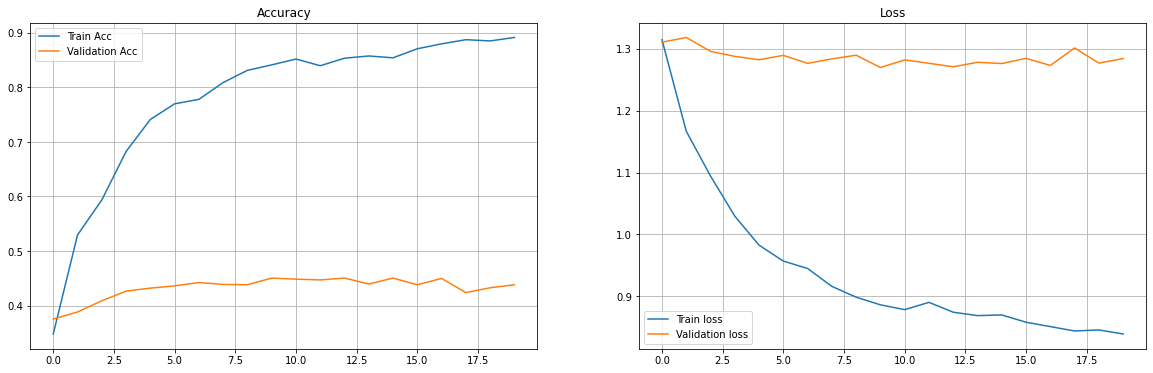

              precision    recall  f1-score   support

       anger       0.45      0.36      0.40       388
        fear       0.38      0.60      0.46       389
         joy       0.62      0.57      0.59       290
     sadness       0.45      0.30      0.36       396

    accuracy                           0.45      1463
   macro avg       0.47      0.46      0.46      1463
weighted avg       0.46      0.45      0.45      1463

Accuracy= 0.4504442925495557
parameters: 64 2 0 0.002 0.0005
Accuracy: 0.4504442925495557


In [31]:
# FIX embedding
hidden_dim = 64
no_layers = 2
dropout = 0
train_emb = False

model = bi_LSTM(hidden_dim, no_layers, dropout, train_emb)

lr = 0.002
w_decay = 5e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=w_decay)

print(25*'==')
print(model)
model_acc = train(model, verbose=True)
print("parameters:", hidden_dim, no_layers, dropout, lr, w_decay)
print("Accuracy:", model_acc)
print(25*'==')

  0%|          | 0/20 [00:00<?, ?it/s]

bi_LSTM(
  (embedding): Embedding(10001, 200)
  (lstm): LSTM(200, 64, num_layers=2, batch_first=True, bidirectional=True)
  (drop): Dropout(p=0, inplace=False)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)


  5%|▌         | 1/20 [00:10<03:10, 10.01s/it]

Epoch 1
train_loss : 1.2811476472351286 val_loss : 1.2960429191589355
train_accuracy : 37.834412841453116 val_accuracy : 38.14080656185919
Validation loss decreased (inf --> 1.296043).  Saving model ...


 10%|█         | 2/20 [00:19<02:59,  9.97s/it]

Epoch 2
train_loss : 1.028768020371596 val_loss : 1.2746428489685058
train_accuracy : 70.45902562658407 val_accuracy : 44.2241968557758
Validation loss decreased (1.296043 --> 1.274643).  Saving model ...


 15%|█▌        | 3/20 [00:29<02:49,  9.97s/it]

Epoch 3
train_loss : 0.8750248435470793 val_loss : 1.2641589562098186
train_accuracy : 86.87693607434525 val_accuracy : 46.069719753930286
Validation loss decreased (1.274643 --> 1.264159).  Saving model ...


 20%|██        | 4/20 [00:39<02:38,  9.93s/it]

Epoch 4
train_loss : 0.8198948692944314 val_loss : 1.2649362405141196
train_accuracy : 91.88960856096874 val_accuracy : 46.069719753930286


 25%|██▌       | 5/20 [00:49<02:28,  9.92s/it]

Epoch 5
train_loss : 0.8036656909518771 val_loss : 1.2604887008666992
train_accuracy : 93.3399042523233 val_accuracy : 46.274777853725226
Validation loss decreased (1.264159 --> 1.260489).  Saving model ...


 30%|███       | 6/20 [00:59<02:19,  9.98s/it]

Epoch 6
train_loss : 0.7971597553955184 val_loss : 1.2616830269495647
train_accuracy : 93.9735285834976 val_accuracy : 46.75324675324675


 35%|███▌      | 7/20 [01:11<02:17, 10.55s/it]

Epoch 7
train_loss : 0.7934705540537834 val_loss : 1.2663720925649007
train_accuracy : 94.3537031822022 val_accuracy : 45.59125085440875


 40%|████      | 8/20 [01:21<02:04, 10.38s/it]

Epoch 8
train_loss : 0.786180805000994 val_loss : 1.2645578463872273
train_accuracy : 95.09997183891862 val_accuracy : 46.13807245386193


 45%|████▌     | 9/20 [01:31<01:52, 10.21s/it]

Epoch 9
train_loss : 0.7797850420077642 val_loss : 1.2694366296132407
train_accuracy : 95.77583779217122 val_accuracy : 45.522898154477105


 50%|█████     | 10/20 [01:41<01:40, 10.08s/it]

Epoch 10
train_loss : 0.7788184632857641 val_loss : 1.2689793666203817
train_accuracy : 95.77583779217122 val_accuracy : 45.79630895420369


 55%|█████▌    | 11/20 [01:51<01:30, 10.04s/it]

Epoch 11
train_loss : 0.7776014564765824 val_loss : 1.2662143548329672
train_accuracy : 95.88848211771332 val_accuracy : 45.933014354066984


 60%|██████    | 12/20 [02:00<01:19,  9.95s/it]

Epoch 12
train_loss : 0.7766653315888511 val_loss : 1.271760352452596
train_accuracy : 95.8603210363278 val_accuracy : 46.274777853725226


 65%|██████▌   | 13/20 [02:10<01:09,  9.89s/it]

Epoch 13
train_loss : 0.7750023975968361 val_loss : 1.2767491817474366
train_accuracy : 96.09969022810476 val_accuracy : 44.77101845522898


 70%|███████   | 14/20 [02:20<00:59,  9.85s/it]

Epoch 14
train_loss : 0.7740400061011314 val_loss : 1.2724019845326742
train_accuracy : 96.09969022810476 val_accuracy : 45.79630895420369


 75%|███████▌  | 15/20 [02:30<00:49,  9.83s/it]

Epoch 15
train_loss : 0.7746913342012299 val_loss : 1.2735971689224244
train_accuracy : 96.04336806533371 val_accuracy : 44.087491455912506


 80%|████████  | 16/20 [02:40<00:39,  9.85s/it]

Epoch 16
train_loss : 0.7806540644831128 val_loss : 1.2656501849492392
train_accuracy : 95.52238805970148 val_accuracy : 45.65960355434039


 85%|████████▌ | 17/20 [02:49<00:29,  9.85s/it]

Epoch 17
train_loss : 0.8024889512194527 val_loss : 1.2679023583730062
train_accuracy : 91.65023936919178 val_accuracy : 45.38619275461381


 90%|█████████ | 18/20 [03:00<00:19,  9.98s/it]

Epoch 18
train_loss : 0.780377183523443 val_loss : 1.2674158573150636
train_accuracy : 95.62095184455083 val_accuracy : 45.86466165413533


 95%|█████████▌| 19/20 [03:10<00:09,  9.99s/it]

Epoch 19
train_loss : 0.7739768293168809 val_loss : 1.2659369548161825
train_accuracy : 96.09969022810476 val_accuracy : 45.317840054682165


100%|██████████| 20/20 [03:19<00:00, 10.00s/it]

Epoch 20
train_loss : 0.7721841873394119 val_loss : 1.2636831760406495
train_accuracy : 96.38130104196001 val_accuracy : 45.79630895420369


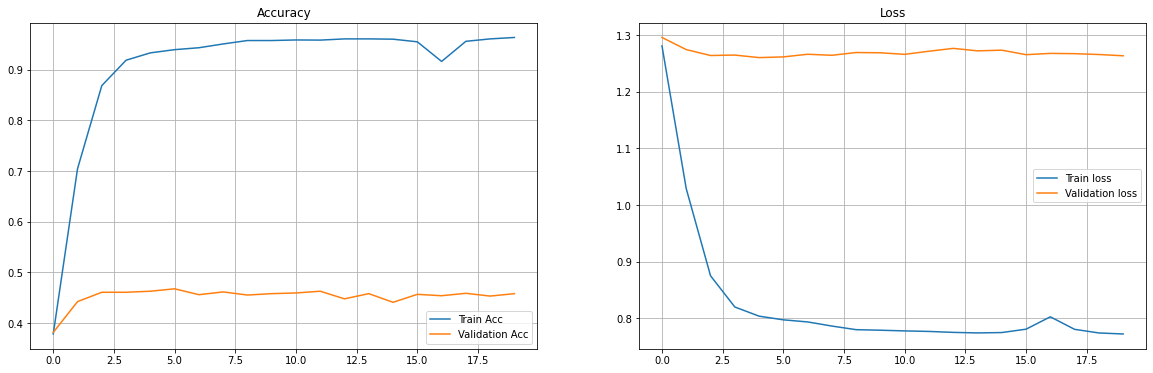

              precision    recall  f1-score   support

       anger       0.48      0.38      0.42       388
        fear       0.39      0.59      0.47       389
         joy       0.59      0.64      0.62       290
     sadness       0.46      0.29      0.35       396

    accuracy                           0.46      1463
   macro avg       0.48      0.47      0.47      1463
weighted avg       0.47      0.46      0.45      1463

Accuracy= 0.46274777853725224
parameters: 64 2 0 0.002 0.0005
Accuracy: 0.46274777853725224


In [32]:
# TRAIN embedding
hidden_dim = 64
no_layers = 2
dropout = 0
train_emb = True

model = bi_LSTM(hidden_dim, no_layers, dropout, train_emb)

lr = 0.002
w_decay = 5e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=w_decay)

print(25*'==')
print(model)
model_acc = train(model, verbose=True)
print("parameters:", hidden_dim, no_layers, dropout, lr, w_decay)
print("Accuracy:", model_acc)
print(25*'==')

## Experiments: LSTM / bi-LSTM

  0%|          | 0/20 [00:00<?, ?it/s]

LSTM(
  (embedding): Embedding(10001, 200)
  (lstm): LSTM(200, 128, num_layers=2, batch_first=True)
  (drop): Dropout(p=0, inplace=False)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)


  5%|▌         | 1/20 [00:08<02:39,  8.39s/it]

Epoch 1
train_loss : 1.288426039947404 val_loss : 1.31688281695048
train_accuracy : 36.38411715009857 val_accuracy : 35.68010936431989
Validation loss decreased (inf --> 1.316883).  Saving model ...


 10%|█         | 2/20 [00:16<02:30,  8.34s/it]

Epoch 2
train_loss : 1.0591672965221934 val_loss : 1.3195258378982544
train_accuracy : 65.26330611095466 val_accuracy : 39.98632946001367


 15%|█▌        | 3/20 [00:24<02:21,  8.32s/it]

Epoch 3
train_loss : 0.9053188098801507 val_loss : 1.2941603899002074
train_accuracy : 83.3990425232329 val_accuracy : 40.94326725905673
Validation loss decreased (1.316883 --> 1.294160).  Saving model ...


 20%|██        | 4/20 [00:33<02:12,  8.27s/it]

Epoch 4
train_loss : 0.8306598274244202 val_loss : 1.2996423721313477
train_accuracy : 91.17150098563785 val_accuracy : 41.55844155844156


 25%|██▌       | 5/20 [00:41<02:03,  8.25s/it]

Epoch 5
train_loss : 0.8055010338624319 val_loss : 1.3017862876256308
train_accuracy : 93.45254857786539 val_accuracy : 41.55844155844156


 30%|███       | 6/20 [00:49<01:57,  8.39s/it]

Epoch 6
train_loss : 0.7947563669747777 val_loss : 1.294450004895528
train_accuracy : 94.66347507744297 val_accuracy : 41.69514695830485


 35%|███▌      | 7/20 [00:56<01:43,  7.95s/it]

Epoch 7
train_loss : 0.7882634078462919 val_loss : 1.2981199820836384
train_accuracy : 95.07181075753309 val_accuracy : 41.83185235816815


 40%|████      | 8/20 [01:03<01:31,  7.64s/it]

Epoch 8
train_loss : 0.7825358799762197 val_loss : 1.3005252917607626
train_accuracy : 95.60687130385807 val_accuracy : 41.35338345864661


 45%|████▌     | 9/20 [01:10<01:19,  7.21s/it]

Epoch 9
train_loss : 0.7799058415823512 val_loss : 1.3011082092920938
train_accuracy : 95.8603210363278 val_accuracy : 40.328092959671906


 50%|█████     | 10/20 [01:16<01:08,  6.85s/it]

Epoch 10
train_loss : 0.7777843417392837 val_loss : 1.3053201278050741
train_accuracy : 95.8180794142495 val_accuracy : 39.98632946001367


 55%|█████▌    | 11/20 [01:21<00:59,  6.58s/it]

Epoch 11
train_loss : 0.7743324596020911 val_loss : 1.3080743948618572
train_accuracy : 96.1982540129541 val_accuracy : 40.66985645933015


 60%|██████    | 12/20 [01:27<00:51,  6.38s/it]

Epoch 12
train_loss : 0.7727730042404599 val_loss : 1.312527887026469
train_accuracy : 96.32497887918896 val_accuracy : 40.19138755980861


 65%|██████▌   | 13/20 [01:34<00:44,  6.31s/it]

Epoch 13
train_loss : 0.7718101441860199 val_loss : 1.3127184470494588
train_accuracy : 96.32497887918896 val_accuracy : 40.328092959671906


 70%|███████   | 14/20 [01:39<00:37,  6.19s/it]

Epoch 14
train_loss : 0.7711722710066371 val_loss : 1.3060167868932089
train_accuracy : 96.28273725711067 val_accuracy : 40.66985645933015


 75%|███████▌  | 15/20 [01:45<00:30,  6.10s/it]

Epoch 15
train_loss : 0.7711696806881163 val_loss : 1.3128915627797444
train_accuracy : 96.4235426640383 val_accuracy : 39.91797676008203


 80%|████████  | 16/20 [01:51<00:24,  6.04s/it]

Epoch 16
train_loss : 0.7724526011281543 val_loss : 1.3073453187942505
train_accuracy : 96.3108983384962 val_accuracy : 40.66985645933015


 85%|████████▌ | 17/20 [01:57<00:17,  6.00s/it]

Epoch 17
train_loss : 0.771421879529953 val_loss : 1.3121500889460245
train_accuracy : 96.29681779780344 val_accuracy : 40.4647983595352


 90%|█████████ | 18/20 [02:03<00:11,  5.96s/it]

Epoch 18
train_loss : 0.7720103123121791 val_loss : 1.3074250141779582
train_accuracy : 96.39538158265277 val_accuracy : 40.73820915926179


 95%|█████████▌| 19/20 [02:09<00:05,  5.94s/it]

Epoch 19
train_loss : 0.7705539191762606 val_loss : 1.312755552927653
train_accuracy : 96.4235426640383 val_accuracy : 40.80656185919344


100%|██████████| 20/20 [02:15<00:00,  6.76s/it]

Epoch 20
train_loss : 0.7695004468162855 val_loss : 1.3152901649475097
train_accuracy : 96.4235426640383 val_accuracy : 40.6015037593985


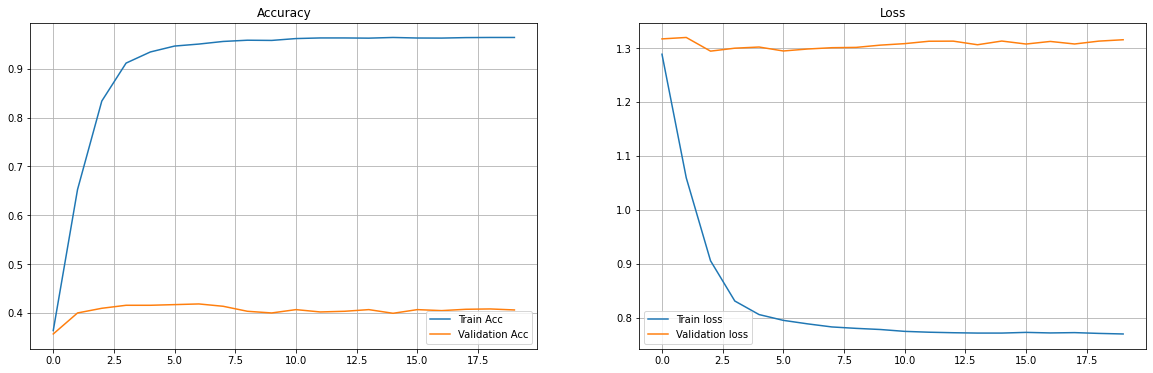

              precision    recall  f1-score   support

       anger       0.44      0.32      0.37       388
        fear       0.37      0.49      0.42       389
         joy       0.50      0.52      0.51       290
     sadness       0.36      0.34      0.35       396

    accuracy                           0.41      1463
   macro avg       0.42      0.42      0.41      1463
weighted avg       0.41      0.41      0.41      1463

Accuracy= 0.4094326725905673
parameters: 128 2 0 0.002 0.0005
Accuracy: 0.4094326725905673


In [33]:
# TRAIN embedding
hidden_dim = 64 * 2
no_layers = 2
dropout = 0
train_emb = True

model = LSTM(hidden_dim, no_layers, dropout, train_emb)

lr = 0.002
w_decay = 5e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=w_decay)

print(25*'==')
print(model)
model_acc = train(model, verbose=True)
print("parameters:", hidden_dim, no_layers, dropout, lr, w_decay)
print("Accuracy:", model_acc)
print(25*'==')

## Experiments: #hidden nodes, #layers, #dropout

In [34]:
best_bilstm_acc = 0
best_model = None
best_parameters = None
BEST_BILSTM_PATH = 'LSTM_working/best_biLSTM_state_dict.pt'

In [35]:
for hidden_dim in [32, 64, 128, 256]:
    for no_layers in [1, 2, 3, 4, 5]:
        for dropout in [0.0, 0.2, 0.4]:
            train_emb = True            
            parameters= (hidden_dim, no_layers, dropout, train_emb)

            model = bi_LSTM(*parameters)

            lr = 0.002
            w_decay = 5e-4
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=w_decay)
            
            model_acc = train(model, verbose=False)
            print("parameters:", hidden_dim, no_layers, dropout, lr, w_decay)
            print("Accuracy: {:0.4f}".format(model_acc))
            
            if model_acc > best_bilstm_acc:
                best_bilstm_acc = model_acc
                best_parameters = parameters
                best_model = model
                os.rename(WORKING_PATH, BEST_BILSTM_PATH) 
            
            print(25*'==')

  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 32 1 0.0 0.002 0.0005
Accuracy: 0.3958


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 32 1 0.2 0.002 0.0005
Accuracy: 0.3917


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 32 1 0.4 0.002 0.0005
Accuracy: 0.3944


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 32 2 0.0 0.002 0.0005
Accuracy: 0.4477


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 32 2 0.2 0.002 0.0005
Accuracy: 0.4614


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 32 2 0.4 0.002 0.0005
Accuracy: 0.3958


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 32 3 0.0 0.002 0.0005
Accuracy: 0.4559


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 32 3 0.2 0.002 0.0005
Accuracy: 0.3103


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 32 3 0.4 0.002 0.0005
Accuracy: 0.3985


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 32 4 0.0 0.002 0.0005
Accuracy: 0.3609


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 32 4 0.2 0.002 0.0005
Accuracy: 0.3172


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 32 4 0.4 0.002 0.0005
Accuracy: 0.3151


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 32 5 0.0 0.002 0.0005
Accuracy: 0.2686


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 32 5 0.2 0.002 0.0005
Accuracy: 0.3117


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 32 5 0.4 0.002 0.0005
Accuracy: 0.2891


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 64 1 0.0 0.002 0.0005
Accuracy: 0.3978


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 64 1 0.2 0.002 0.0005
Accuracy: 0.3985


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 64 1 0.4 0.002 0.0005
Accuracy: 0.3910


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 64 2 0.0 0.002 0.0005
Accuracy: 0.4662


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 64 2 0.2 0.002 0.0005
Accuracy: 0.4668


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 64 2 0.4 0.002 0.0005
Accuracy: 0.4491


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 64 3 0.0 0.002 0.0005
Accuracy: 0.3964


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 64 3 0.2 0.002 0.0005
Accuracy: 0.3889


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 64 3 0.4 0.002 0.0005
Accuracy: 0.4607


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 64 4 0.0 0.002 0.0005
Accuracy: 0.3903


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 64 4 0.2 0.002 0.0005
Accuracy: 0.3527


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 64 4 0.4 0.002 0.0005
Accuracy: 0.3315


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 64 5 0.0 0.002 0.0005
Accuracy: 0.3548


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 64 5 0.2 0.002 0.0005
Accuracy: 0.2809


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 64 5 0.4 0.002 0.0005
Accuracy: 0.3643


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 128 1 0.0 0.002 0.0005
Accuracy: 0.4163


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 128 1 0.2 0.002 0.0005
Accuracy: 0.4033


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 128 1 0.4 0.002 0.0005
Accuracy: 0.4019


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 128 2 0.0 0.002 0.0005
Accuracy: 0.4655


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 128 2 0.2 0.002 0.0005
Accuracy: 0.4675


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 128 2 0.4 0.002 0.0005
Accuracy: 0.4607


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 128 3 0.0 0.002 0.0005
Accuracy: 0.4498


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 128 3 0.2 0.002 0.0005
Accuracy: 0.4539


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 128 3 0.4 0.002 0.0005
Accuracy: 0.4662


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 128 4 0.0 0.002 0.0005
Accuracy: 0.4402


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 128 4 0.2 0.002 0.0005
Accuracy: 0.3964


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 128 4 0.4 0.002 0.0005
Accuracy: 0.4129


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 128 5 0.0 0.002 0.0005
Accuracy: 0.3739


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 128 5 0.2 0.002 0.0005
Accuracy: 0.3390


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 128 5 0.4 0.002 0.0005
Accuracy: 0.3554


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 256 1 0.0 0.002 0.0005
Accuracy: 0.4306


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 256 1 0.2 0.002 0.0005
Accuracy: 0.4293


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 256 1 0.4 0.002 0.0005
Accuracy: 0.4238


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 256 2 0.0 0.002 0.0005
Accuracy: 0.4518


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 256 2 0.2 0.002 0.0005
Accuracy: 0.4662


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 256 2 0.4 0.002 0.0005
Accuracy: 0.4655


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 256 3 0.0 0.002 0.0005
Accuracy: 0.4785


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 256 3 0.2 0.002 0.0005
Accuracy: 0.4655


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 256 3 0.4 0.002 0.0005
Accuracy: 0.3424


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 256 4 0.0 0.002 0.0005
Accuracy: 0.3992


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 256 4 0.2 0.002 0.0005
Accuracy: 0.3930


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 256 4 0.4 0.002 0.0005
Accuracy: 0.3527


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 256 5 0.0 0.002 0.0005
Accuracy: 0.3363


  0%|          | 0/20 [00:00<?, ?it/s]

parameters: 256 5 0.2 0.002 0.0005
Accuracy: 0.2891


100%|██████████| 20/20 [30:40<00:00, 92.00s/it]


parameters: 256 5 0.4 0.002 0.0005
Accuracy: 0.2659


In [42]:
best_parameters

(256, 3, 0.0, True)

In [36]:
best_model = bi_LSTM(*best_parameters)
best_model.load_state_dict(torch.load(BEST_BILSTM_PATH))
best_model.eval()

bi_LSTM(
  (embedding): Embedding(10001, 200)
  (lstm): LSTM(200, 256, num_layers=3, batch_first=True, bidirectional=True)
  (drop): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=512, out_features=4, bias=True)
)

In [40]:
inputs = [torch.from_numpy(t) for t in X_dev]
output = best_model(inputs)
y_pred = torch.argmax(output, 1).data.numpy()
print(classification_report(y_dev, y_pred, target_names=EMOTIONS))
print("Accuracy=", accuracy_score(y_dev, y_pred))

              precision    recall  f1-score   support

       anger       0.47      0.40      0.43       388
        fear       0.41      0.55      0.47       389
         joy       0.67      0.64      0.66       290
     sadness       0.44      0.36      0.40       396

    accuracy                           0.48      1463
   macro avg       0.50      0.49      0.49      1463
weighted avg       0.48      0.48      0.48      1463

Accuracy= 0.4784688995215311


## qualitative analysis

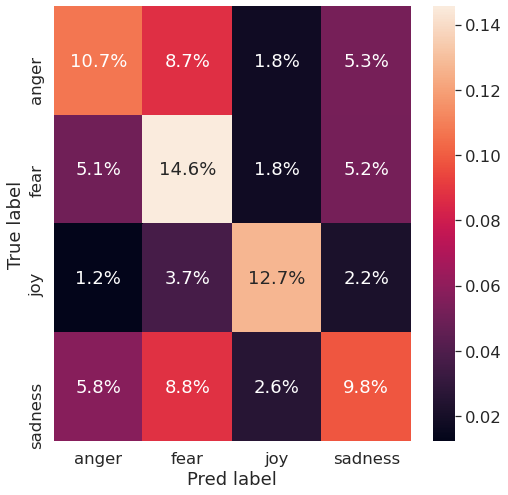

In [47]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_dev, y_pred)
plt.figure(figsize=(8,8))
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), fmt='.1%', annot=True, xticklabels=EMOTIONS, yticklabels=EMOTIONS)
ax.set(xlabel='Pred label', ylabel='True label')
sns.set(font_scale=1.4)
plt.show()